# 서울시 부동산 실거래가 분석하기

# 1. 모듈 불러오기 

In [2]:
from IPython.display import Image


# 데이터 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 선형 회귀 모델
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 정규화 모델
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV ,RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve, cross_val_score, KFold

# 부스팅 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import torch

# 데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm

# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic')

# 2. 데이터 불러오기

## 데이터 구조
- 데이터 : 국토교통부, 통계청, 네이버 부동산, 구글맵, 부동산 114 등
- 관측치 개수 : ***개
- 변수 개수 : ***개 

## 설명 변수 (원인 : 예측값을 설명할 수 있는 변수)

### 구조적 특성
- 단지명(csv)
- 전용 면적 (csv) : 단지명이랑 전용 면적을 줄기로 파생 데이터를 붙여야됨 
- 건축년도 (csv)
- 층 수 (csv) 
- 방 수 (m. 네이버 부동산)
- 화장실 수 (m. 네이버 부동산) : 기존의 부동산 가격을 분석했던 헤도닉 모형에 공통적으로 포함되어 있음
- 난방 (m.네이버 부동산) : 2008년 원두환·김형건(난방 방식에 따른 아파트 가격 변화 분석) 참조

 
### 환경적 특성
- 크기 (총 세대 수, 동 수) (m.네이버 부동산) : 도시경제학에서 군집 효과의 크기를 의미
- 평균 주차 가능 대수 (m.네이버 부동산) : 아파트 단지 내 가구당 주차수요가 증가하면서 점차 중요한 요인으로 고려되고 있음.
- 단지 내 최고층의 높이 (m.네이버 부동산) : 단지 내의 조경
- 최저층의 높이 (m.네이버 부동산)
- 건폐율 (m.네이버 부동산) : 건축면적에 대한 대지면적의 비율
- 용적률 (m.네이버 부동산) : 총면적의 대지면적에 대한 비율 -> 재건축 시 기대할 수 있는 수익과 직접적인 연관

### 입지적 특성
- 주요 시설과의 거리 (m.네이버 부동산) : 버스, 지하철, 학교, 어린이집, 유치원, 마트, 편의점 ,세탁소, 은행
- 병원은 1km 이내가 5%밖에 안되서 의사/환자수로 대체 요망

### 정책 반영
- 자잘한 대책들 제외하고 LTV, DTI / 종소세, 양도세 보유세 건드린 것들만 반영



## 반응 변수 (결과 : 예측하고자 하는 값)
- 매매가격 (국토 교통부 아파트 매매 실거래가)

-  ComplexName(건물명) : object        
-  Area(전용면적) : float64       
-  Floor(층) : int64         
-  Construct(건설년도) : int64         
-  Addr(주소) : object        
-  gu(구 코드) : int64                        =>          string으로 변경 후 label encoding       
-  dong(동 코드) : int64              
-  apt(아파트 코드) : int64         
-  household(총 세대 수) : object        
-  floor_low(최저층) : int64         
-  floor_top(최고층) : int64         
-  parking(총 주차 수) : object        
-  floor_area(용적) : float64       
-  building_cover(건폐 : float64       
-  construction(건설사) : object             =>          (순위 개념 도입?)  삭제? 
-  heating : object                          =>          인코딩
-  bus : object                           
-  subway : object                           =>          역세권 개념 : 500m 이내 
-  child : object        
-  preschool : object                        =>          유치원/어린이집/학교 
-  school : object        
-  parking_lot : object        
-  market : object        
-  convenience : object                      =>          편세권 
-  laundry : object        
-  bank : object        
-  hospital : object                         =>          병원은 구별로 1인당 의사로 하는게 좋을듯 (병원의 거리가 너무 멀어서) / 삭제.?
-  contract : datetime64[ns] :              
-  policy_1 : int64         
-  policy_2 : int64         
-  policy_3 : int64         
-  policy_4 : int64         
-  policy_5 : int64         
-  policy_6 : int64         
-  policy_7 : int64         
-  policy_8 : int64         
-  policy_9 : int64         
-  policy_10 : int64                         

# 3. 데이터 전처리
- X : 독립변수, 예측변수, 입력변수
- y : 종속변수, 반응변수, 출력변수

## 부동산 데이터 수집 
- 네이버 부동산 (pc) : https://new.land.naver.com/complexes/22853?ms=37.5085491,127.0104349,17&a=APT&b=A1&e=RETAIL&ad=true
- 네이버 부동산 (모바일) : https://m.land.naver.com/complex/info/22853?ptpNo=1
- complex 다음 숫자가 아파트 번호 코드
- 아파트 번호를 리스트화해서 for 반복문을 통해 크롤링
- 모바일 데이터는 html 파싱하는 방식으로 크롤링

### 모바일 데이터로 얻을 수 있는 데이터의 정보 (object, float, int)

- 세대수
- 최저/최고층  
- 총주차대수 : 총주차대수/세대수로 수정 요망
- 사용승인일
- 용적률
- 건폐율
- 건설사
- 난방
- 면적 : 평수로 바꿀 예정
- 주변 편의시설/1km 이내 : 병원은 구를 기준 삼아 의사/인구수 비율로 수정 요망
- 주변 대중교통 (ex. 지하철 7 , 버스 50) : 역세권 개념을 정의해야될듯(500m?)

In [283]:
df17=pd.read_csv('data/아파트실거래가_17.csv',encoding='cp949')
df18=pd.read_csv('data/아파트실거래가_18.csv',encoding='cp949')
df19=pd.read_csv('data/아파트실거래가_19.csv',encoding='cp949')
df20=pd.read_csv('data/아파트실거래가_20.csv',encoding='cp949')
df21=pd.read_csv('data/아파트실거래가_21.09.csv',encoding='cp949')

In [284]:
df1 = pd.concat([df17,df18, df19, df20, df21])
df1

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일
0,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,201703,15,"80,000",7,1988,언주로 103,NaN
1,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,201704,19,"85,000",2,1988,언주로 103,NaN
2,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,201707,8,"89,900",1,1988,언주로 103,NaN
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,201704,13,"97,500",4,1987,언주로 3,NaN
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,201704,17,"98,000",1,1987,언주로 3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38201,서울특별시 중랑구 중화동,450,450.0,0.0,한신2,84.03,202108,21,"88,000",3,1998,동일로 752,NaN
38202,서울특별시 중랑구 중화동,274-51,274.0,51.0,한영(101),57.66,202102,27,"30,500",5,2003,동일로144길 74,NaN
38203,서울특별시 중랑구 중화동,274-75,274.0,75.0,한영(102),72.22,202105,4,"49,500",4,2003,동일로144길 74,NaN
38204,서울특별시 중랑구 중화동,274-76,274.0,76.0,한영(103),58.46,202107,1,"30,000",2,2003,동일로144길 74,NaN


In [285]:
df1.drop(['해제사유발생일'], axis=1, inplace=True)

In [286]:
df1['Addr'] = df1['시군구']+df1['번지']

In [287]:
df1.drop(['시군구', '번지', '본번', '부번', '도로명'], axis=1, inplace=True)
df1

,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,Addr
0,개포2차현대아파트(220),77.75,201703,15,"80,000",7,1988,서울특별시 강남구 개포동655-2
1,개포2차현대아파트(220),77.75,201704,19,"85,000",2,1988,서울특별시 강남구 개포동655-2
2,개포2차현대아파트(220),77.75,201707,8,"89,900",1,1988,서울특별시 강남구 개포동655-2
3,개포6차우성아파트1동~8동,79.97,201704,13,"97,500",4,1987,서울특별시 강남구 개포동658-1
4,개포6차우성아파트1동~8동,79.97,201704,17,"98,000",1,1987,서울특별시 강남구 개포동658-1
...,...,...,...,...,...,...,...,...
38201,한신2,84.03,202108,21,"88,000",3,1998,서울특별시 중랑구 중화동450
38202,한영(101),57.66,202102,27,"30,500",5,2003,서울특별시 중랑구 중화동274-51
38203,한영(102),72.22,202105,4,"49,500",4,2003,서울특별시 중랑구 중화동274-75
38204,한영(103),58.46,202107,1,"30,000",2,2003,서울특별시 중랑구 중화동274-76


In [288]:
df1.rename(columns={'단지명':'ComplexName', '전용면적(㎡)':'Area', '거래금액(만원)':'Price','층':'Floor', '건축년도' :'Construct'}, inplace=True)
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr
0,개포2차현대아파트(220),77.75,201703,15,"80,000",7,1988,서울특별시 강남구 개포동655-2
1,개포2차현대아파트(220),77.75,201704,19,"85,000",2,1988,서울특별시 강남구 개포동655-2
2,개포2차현대아파트(220),77.75,201707,8,"89,900",1,1988,서울특별시 강남구 개포동655-2
3,개포6차우성아파트1동~8동,79.97,201704,13,"97,500",4,1987,서울특별시 강남구 개포동658-1
4,개포6차우성아파트1동~8동,79.97,201704,17,"98,000",1,1987,서울특별시 강남구 개포동658-1
...,...,...,...,...,...,...,...,...
38201,한신2,84.03,202108,21,"88,000",3,1998,서울특별시 중랑구 중화동450
38202,한영(101),57.66,202102,27,"30,500",5,2003,서울특별시 중랑구 중화동274-51
38203,한영(102),72.22,202105,4,"49,500",4,2003,서울특별시 중랑구 중화동274-75
38204,한영(103),58.46,202107,1,"30,000",2,2003,서울특별시 중랑구 중화동274-76


In [289]:
df=pd.read_csv('data/df_result.csv',encoding='cp949')
df

,gu,dong,apt,title,household,floor_low,floor_top,parking,floor_area,building_cover,construction,heating,bus,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,1168000000,1168010300,8928,LG개포자이,212,20,22,502,250.0,18.0,LG건설(주),지역난방열병합,217m,380m,183m,414m,112m,266m,325m,244m,38m,302m,1001
1,1168000000,1168010300,119219,개포래미안포레스트,"2,296",7,35,"3,961",249.0,21.0,삼성물산(주),지역난방열병합,162m,1001,131m,131m,269m,437m,495m,133m,324m,281m,1001
2,1168000000,1168010300,140057,개포비버리하임(도시형),29,6,6,15,199.0,57.0,NaN,개별난방도시가스,110m,1001,161m,169m,223m,120m,359m,17m,90m,131m,1001
3,1168000000,1168010300,107513,개포상지리츠빌,18,10,10,41,202.0,31.0,상지건영(주),개별난방도시가스,138m,80m,609m,534m,192m,525m,509m,409m,83m,459m,1001
4,1168000000,1168010300,103385,개포현대(200동),72,9,9,NaN,157.0,17.0,현대건설,개별난방도시가스,81m,769m,15m,269m,109m,435m,170m,115m,152m,107m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8368,1126000000,1126010300,104106,태솔,19,3,6,20,199.0,47.0,(주)프름에씨앤씨,개별난방도시가스,116m,275m,127m,131m,1001,46m,112m,75m,69m,110m,1001
8369,1126000000,1126010300,102174,한솔e,35,7,7,35,0.0,0.0,"인수종합건설(주),원섭종합건설(주)",개별난방도시가스,159m,387m,122m,165m,126m,184m,167m,78m,89m,388m,1001
8370,1126000000,1126010300,824,한신,"1,544",23,27,"1,548",376.0,20.0,한신공영,개별난방도시가스,187m,240m,59m,102m,123m,229m,216m,179m,113m,230m,1001
8371,1126000000,1126010300,18519,한영,72,5,7,73,294.0,58.0,(주)세광종합건설,개별난방도시가스,323m,512m,163m,306m,145m,326m,88m,180m,166m,380m,1001


In [290]:
df.rename(columns={'title':'ComplexName'}, inplace=True)
df

,gu,dong,apt,ComplexName,household,floor_low,floor_top,parking,floor_area,building_cover,construction,heating,bus,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,1168000000,1168010300,8928,LG개포자이,212,20,22,502,250.0,18.0,LG건설(주),지역난방열병합,217m,380m,183m,414m,112m,266m,325m,244m,38m,302m,1001
1,1168000000,1168010300,119219,개포래미안포레스트,"2,296",7,35,"3,961",249.0,21.0,삼성물산(주),지역난방열병합,162m,1001,131m,131m,269m,437m,495m,133m,324m,281m,1001
2,1168000000,1168010300,140057,개포비버리하임(도시형),29,6,6,15,199.0,57.0,NaN,개별난방도시가스,110m,1001,161m,169m,223m,120m,359m,17m,90m,131m,1001
3,1168000000,1168010300,107513,개포상지리츠빌,18,10,10,41,202.0,31.0,상지건영(주),개별난방도시가스,138m,80m,609m,534m,192m,525m,509m,409m,83m,459m,1001
4,1168000000,1168010300,103385,개포현대(200동),72,9,9,NaN,157.0,17.0,현대건설,개별난방도시가스,81m,769m,15m,269m,109m,435m,170m,115m,152m,107m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8368,1126000000,1126010300,104106,태솔,19,3,6,20,199.0,47.0,(주)프름에씨앤씨,개별난방도시가스,116m,275m,127m,131m,1001,46m,112m,75m,69m,110m,1001
8369,1126000000,1126010300,102174,한솔e,35,7,7,35,0.0,0.0,"인수종합건설(주),원섭종합건설(주)",개별난방도시가스,159m,387m,122m,165m,126m,184m,167m,78m,89m,388m,1001
8370,1126000000,1126010300,824,한신,"1,544",23,27,"1,548",376.0,20.0,한신공영,개별난방도시가스,187m,240m,59m,102m,123m,229m,216m,179m,113m,230m,1001
8371,1126000000,1126010300,18519,한영,72,5,7,73,294.0,58.0,(주)세광종합건설,개별난방도시가스,323m,512m,163m,306m,145m,326m,88m,180m,166m,380m,1001


In [291]:
df1 = pd.merge(df1, df, how='inner', on='ComplexName')
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,apt,household,floor_low,floor_top,parking,floor_area,building_cover,construction,heating,bus,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,134.86,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
1,개포현대6차,132.63,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
2,개포현대6차,132.63,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
3,경남2차,182.20,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140m,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
4,경남2차,91.91,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140m,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,26.33,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628137,이지마루종로,24.44,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628138,이지마루종로,26.65,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628139,청구드림,84.99,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,26959,19,7,7,23,268.0,44.0,NaN,개별난방도시가스,142m,183m,24m,406m,87m,86m,215m,23m,151m,172m,1001


## 전처리


- 평수 , 'm'빼기 , 계약날짜 컬럼 완료
- 정책 더미 아직

In [292]:
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,apt,household,floor_low,floor_top,parking,floor_area,building_cover,construction,heating,bus,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,134.86,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
1,개포현대6차,132.63,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
2,개포현대6차,132.63,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
3,경남2차,182.20,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140m,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
4,경남2차,91.91,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140m,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,26.33,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628137,이지마루종로,24.44,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628138,이지마루종로,26.65,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628139,청구드림,84.99,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,26959,19,7,7,23,268.0,44.0,NaN,개별난방도시가스,142m,183m,24m,406m,87m,86m,215m,23m,151m,172m,1001


- 제곱미터 -> 평수 

In [293]:
df1['Area']=round( df1['Area']/3.3)

In [294]:
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,apt,household,floor_low,floor_top,parking,floor_area,building_cover,construction,heating,bus,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,41.0,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
1,개포현대6차,40.0,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
2,개포현대6차,40.0,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131m,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
3,경남2차,55.0,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140m,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
4,경남2차,28.0,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140m,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628137,이지마루종로,7.0,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628138,이지마루종로,8.0,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146m,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628139,청구드림,26.0,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,26959,19,7,7,23,268.0,44.0,NaN,개별난방도시가스,142m,183m,24m,406m,87m,86m,215m,23m,151m,172m,1001


- m 빼기

In [295]:
# m 빼기
columns = ['bus','subway','child','preschool','school','parking_lot','market','convenience','laundry','bank','hospital']
for col in columns:
    df1[col] = df1[col].str.strip("m")

In [296]:
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,apt,household,floor_low,floor_top,parking,floor_area,building_cover,construction,heating,bus,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,41.0,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131,812,66,479,489,155,313,88,202,172,1001
1,개포현대6차,40.0,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131,812,66,479,489,155,313,88,202,172,1001
2,개포현대6차,40.0,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,4,8,19,238.0,42.0,현대산업개발(주),개별난방도시가스,131,812,66,479,489,155,313,88,202,172,1001
3,경남2차,55.0,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140,452,177,1001,230,114,1001,132,135,208,1001
4,경남2차,28.0,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,8,11,99,0.0,0.0,경남기업 (주),개별난방도시가스,140,452,177,1001,230,114,1001,132,135,208,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146,346,181,252,99,111,1001,40,209,241,1001
628137,이지마루종로,7.0,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146,346,181,252,99,111,1001,40,209,241,1001
628138,이지마루종로,8.0,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,15,16,51,532.0,53.0,(주)수영종합건설,개별난방도시가스,146,346,181,252,99,111,1001,40,209,241,1001
628139,청구드림,26.0,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,26959,19,7,7,23,268.0,44.0,NaN,개별난방도시가스,142,183,24,406,87,86,215,23,151,172,1001


- 날짜 : 계약년월+ 계약일 --> 계약날짜 컬럼으로 생성 

In [297]:
df1['계약날짜']=df1['계약년월'].astype(str)  +df1['계약일'].astype(str)
df1['계약날짜']=pd.to_datetime(df1["계약날짜"], format='%Y%m%d')

In [298]:
df1[["계약년월","계약일","계약날짜"]]

,계약년월,계약일,계약날짜
0,201706,26,2017-06-26
1,201707,8,2017-07-08
2,201901,13,2019-01-13
3,201702,11,2017-02-11
4,201702,11,2017-02-11
...,...,...,...
628136,202109,27,2021-09-27
628137,202109,28,2021-09-28
628138,202109,29,2021-09-29
628139,202103,27,2021-03-27


In [299]:
df1.shape

(628141, 31)

- 정책 적용

In [300]:
import datetime

In [301]:
policy_1_date = datetime.date(2017, 6, 19)
policy_2_date = datetime.date(2017, 8, 2)
policy_3_date = datetime.date(2017, 9, 5)
policy_4_date = datetime.date(2017, 10, 24)
policy_5_date = datetime.date(2018, 9, 13)
policy_6_date = datetime.date(2018, 12, 19)
# 정책 6번 날짜정보 애매함
# https://namu.wiki/w/3%EA%B8%B0%20%EC%8B%A0%EB%8F%84%EC%8B%9C?rev=197
policy_7_date = datetime.date(2019, 12, 16)
policy_8_date = datetime.date(2020, 6, 17)
policy_9_date = datetime.date(2020, 7, 10)
policy_10_date = datetime.date(2020, 8, 4)

policy_date = [policy_1_date, policy_2_date,policy_3_date,policy_4_date,policy_5_date,
             policy_6_date,policy_7_date,policy_8_date,policy_9_date,policy_10_date]

In [302]:
policy_date

[datetime.date(2017, 6, 19),
 datetime.date(2017, 8, 2),
 datetime.date(2017, 9, 5),
 datetime.date(2017, 10, 24),
 datetime.date(2018, 9, 13),
 datetime.date(2018, 12, 19),
 datetime.date(2019, 12, 16),
 datetime.date(2020, 6, 17),
 datetime.date(2020, 7, 10),
 datetime.date(2020, 8, 4)]

In [303]:
policy_col = ["policy_1", "policy_2","policy_3","policy_4","policy_5",
              "policy_6","policy_7","policy_8","policy_9","policy_10"]

In [304]:
for date, col in zip(policy_date, policy_col):
    df1[col] = df1["계약날짜"].apply(lambda x: 1 if x >= date else 0)

C:\Users\CPBUserN\AppData\Local\Temp/ipykernel_1724/2738732511.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df1[col] = df1["계약날짜"].apply(lambda x: 1 if x >= date else 0)


KeyboardInterrupt: 

In [ ]:
df1[policy_col].head()

In [ ]:
df1["계약날짜"].head()

In [ ]:
df1.rename(columns={'계약날짜':'contract'}, inplace=True)
df1

In [ ]:
df1.drop(['계약년월', '계약일'], axis=1, inplace=True)
df1

In [ ]:
df1.drop(['construction', 'hospital'], axis=1, inplace=True)

In [ ]:
df1.drop(['dong'], axis=1, inplace=True)

In [ ]:
df1.dropna(inplace=True)

## Null 확인 및 대체
- Null, NaN, NA, '정해지지 않은 값' 개수 확인

In [ ]:
df1['parking']= df1['parking'].str.replace(',', '').astype('int64')

In [ ]:
df1['household']= df1['household'].str.replace(',', '').astype('int64')

In [ ]:
df1['Price']= df1['Price'].str.replace(',', '').astype('int64')

In [ ]:
df1['parking'] = df1['parking']/df1['household']

In [ ]:
df1['parking']=round(df1['parking'],2)

In [ ]:
for categ in ['subway', 'bus', 'child', 'preschool', 'school', 'parking_lot', 'market', 'convenience', 'laundry', 'bank']:
    df1[categ] = df1[categ].astype('int64')

In [ ]:
df1.info()

In [ ]:
# df파일 저장
df1.to_csv('data/raw_data.csv',index=False, encoding='cp949')

# !!!!!!!!!!!!!!!여기부터 시작하셈!!!!!!!!!!!!

In [3]:
df=pd.read_csv('df_save_20000.csv',encoding='cp949')
df

,Area,Floor,Construct,gu,household,floor_low,floor_top,parking,floor_area,building_cover,...,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10,Price
0,2.833213,0.693147,1987,17,6.383507,2.397895,15,0.530628,0.000000,0.000000,...,0.693147,0.693147,0.693147,0,0,0.000000,0.000000,0.000000,0.000000,27500.0
1,2.564949,2.302585,2019,11,3.806662,2.708050,14,0.598837,5.886104,3.761200,...,0.693147,0.693147,0.693147,1,1,0.693147,0.000000,0.000000,0.000000,37200.0
2,2.890372,1.386294,1988,22,5.579730,2.302585,18,0.708036,5.932245,3.496508,...,0.693147,0.693147,0.693147,1,1,0.693147,0.693147,0.000000,0.000000,47000.0
3,3.295837,2.079442,2001,18,7.436617,2.564949,28,0.810930,5.783825,2.995732,...,0.693147,0.693147,0.693147,1,1,0.000000,0.000000,0.000000,0.000000,70000.0
4,2.944439,3.044522,1998,12,6.863803,2.397895,18,0.559616,5.860786,3.332205,...,0.693147,0.693147,0.693147,0,0,0.000000,0.000000,0.000000,0.000000,41000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19898,3.295837,2.708050,2003,17,5.963579,3.044522,22,0.708036,5.891644,3.218876,...,0.693147,0.693147,0.693147,1,1,0.693147,0.693147,0.693147,0.693147,120000.0
19899,2.944439,1.386294,1998,5,6.400257,2.639057,25,0.774727,5.826000,3.135494,...,0.693147,0.693147,0.693147,1,1,0.693147,0.000000,0.000000,0.000000,63500.0
19900,3.295837,2.564949,2006,4,5.017280,2.079442,19,0.667829,5.758902,3.367296,...,0.693147,0.693147,0.693147,0,0,0.000000,0.000000,0.000000,0.000000,49950.0
19901,3.637586,2.564949,1993,5,5.488938,2.484907,15,0.604316,5.517453,0.000000,...,0.693147,0.693147,0.693147,0,0,0.000000,0.000000,0.000000,0.000000,68000.0


In [30]:
df.shape

(19903, 34)

# 4. 모델링
- randomgridsearch 위주 
- 샘플링 필요 (stratify = 년도로 지정해서)

In [4]:
y = df.loc[:,'Price']
X = df.drop(['Price', 'contract'], axis=1)


display(X.head(3))

,Area,Floor,Construct,gu,household,floor_low,floor_top,parking,floor_area,building_cover,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,2.833213,0.693147,1987,17,6.383507,2.397895,15,0.530628,0.000000,0.000000,...,0.693147,0.693147,0.693147,0.693147,0,0,0.000000,0.000000,0.0,0.0
1,2.564949,2.302585,2019,11,3.806662,2.708050,14,0.598837,5.886104,3.761200,...,0.693147,0.693147,0.693147,0.693147,1,1,0.693147,0.000000,0.0,0.0
2,2.890372,1.386294,1988,22,5.579730,2.302585,18,0.708036,5.932245,3.496508,...,0.693147,0.693147,0.693147,0.693147,1,1,0.693147,0.693147,0.0,0.0


In [5]:
# Train Set / Test Set 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     test_size=0.3, random_state=2021) 
                                                    # stratify = y 옵션의 의미 : 극단적으로 1, 0이 나뉘는 경우 방지

# 데이터 컬럼 단위 정규화 하기
# normalizer = StandardScaler()
# X_train = normalizer.fit_transform(X_train)
# X_test = normalizer.transform(X_test)

print(f'Train Set dimension is {X_train.shape}')
print(f'Test Set dimension is {X_test.shape}')

Train Set dimension is (13932, 32)
Test Set dimension is (5971, 32)


In [64]:
y.tail()

19898    120000.0
19899     63500.0
19900     49950.0
19901     68000.0
19902     73000.0
Name: Price, dtype: float64

In [65]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19903 entries, 0 to 19902
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area            19903 non-null  float64
 1   Floor           19903 non-null  float64
 2   Construct       19903 non-null  int64  
 3   gu              19903 non-null  int64  
 4   household       19903 non-null  float64
 5   floor_low       19903 non-null  float64
 6   floor_top       19903 non-null  int64  
 7   parking         19903 non-null  float64
 8   floor_area      19903 non-null  float64
 9   building_cover  19903 non-null  float64
 10  construction    19903 non-null  float64
 11  heating         19903 non-null  int64  
 12  bus             19903 non-null  int64  
 13  subway          19903 non-null  int64  
 14  child           19903 non-null  int64  
 15  preschool       19903 non-null  int64  
 16  school          19903 non-null  int64  
 17  parking_lot     19903 non-null 

- 선형회귀(Linear)
- 정규화 (Normalization)
- 부스팅(lightBGM)
- 샘플링 10%만 해서 모델이 잘 돌아가는지 확인 후에
- GU는 STRING으로 바꿔서 LABEL ENCODING

## 4.1 EDA

### 이상치 확인

<Figure size 432x288 with 0 Axes>

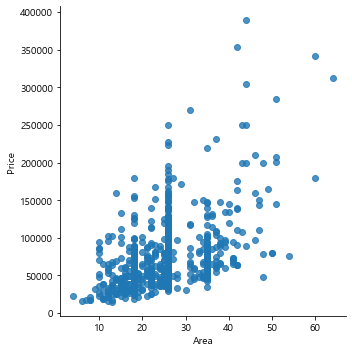

In [10]:
# train_df 이상치 확인
plt.figure()
otl = sns.lmplot(data = train_df, x = "Area", y="Price", fit_reg=False)

In [8]:
# test_df 이상치 확인
plt.figure()
otl = sns.lmplot(data = y_test, x = "Area", y="Price", fit_reg=False)

KeyError: "None of [Index(['Area', 'Price'], dtype='object')] are in the [index]"

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

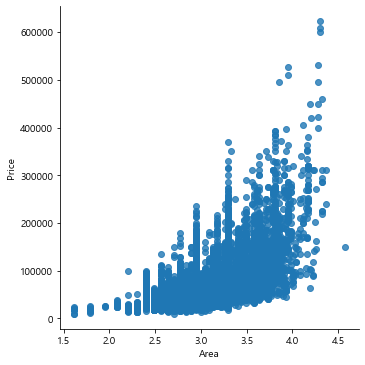

In [9]:
# 모든 데이터의 이상치
plt.figure()
otl = sns.lmplot(data = df, x = "Area", y="Price", fit_reg=False)

In [13]:
print(train_df.shape)

(1000, 36)


### target y 값에 대한 분포 확인
- 분포의 모양
- 왜도 파악

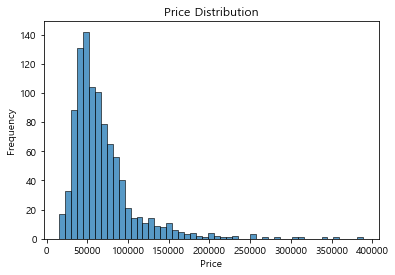

C:\Users\CPBUserN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\CPBUserN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


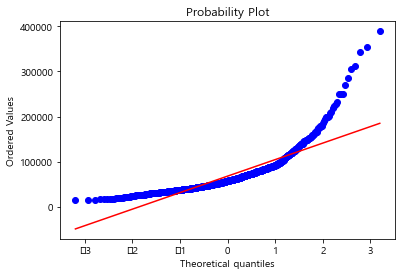

Skewness: 2.778


In [14]:
sns.histplot(train_df['Price'])
plt.title('Price Distribution')
plt.ylabel('Frequency')
plt.figure()

qq = stats.probplot(np.array(train_df['Price']), plot=plt)
plt.show()
print("Skewness: {:.3f}".format(train_df['Price'].skew()))

In [15]:
# log1p : log(1 + input)
train_df['Price'] = np.log1p(train_df['Price'])

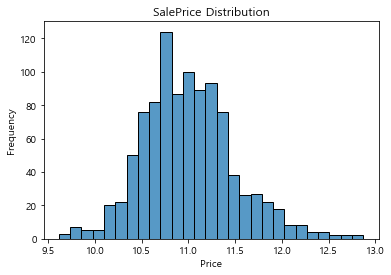

C:\Users\CPBUserN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\CPBUserN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


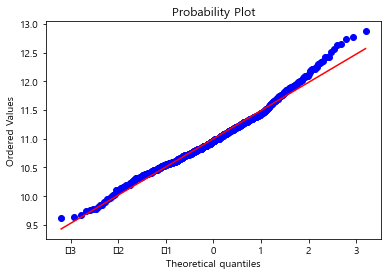

Skewness: 0.472


In [16]:
sns.histplot(train_df['Price'])
plt.title('SalePrice Distribution')
plt.ylabel('Frequency')

plt.figure()
qq = stats.probplot(np.array(train_df['Price']), plot=plt)
plt.show()

print("Skewness: {:.3f}".format(train_df['Price'].skew()))

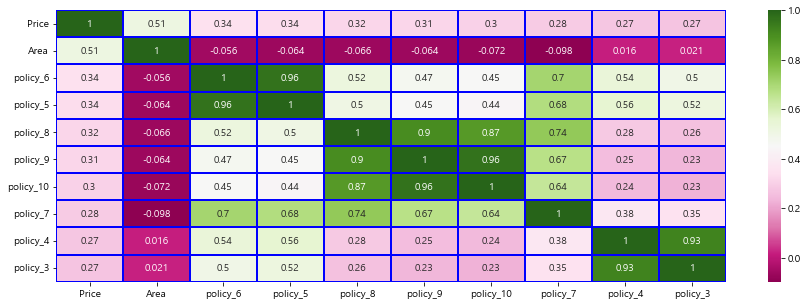

In [19]:
plt.figure(figsize=(15,5))
corr_train = train_df.corr()

num = 10 # 수정하면 전체 상관관계 볼 수 있음
col = corr_train.nlargest(num, 'Price')['Price'].index
coeff = np.corrcoef(train_df[col].values.T)

# heatmap
heatmp = sns.heatmap(coeff, 
                     annot = True, 
                     xticklabels = col.values, yticklabels = col.values, 
                     linewidth=2,cmap='PiYG', linecolor='blue')

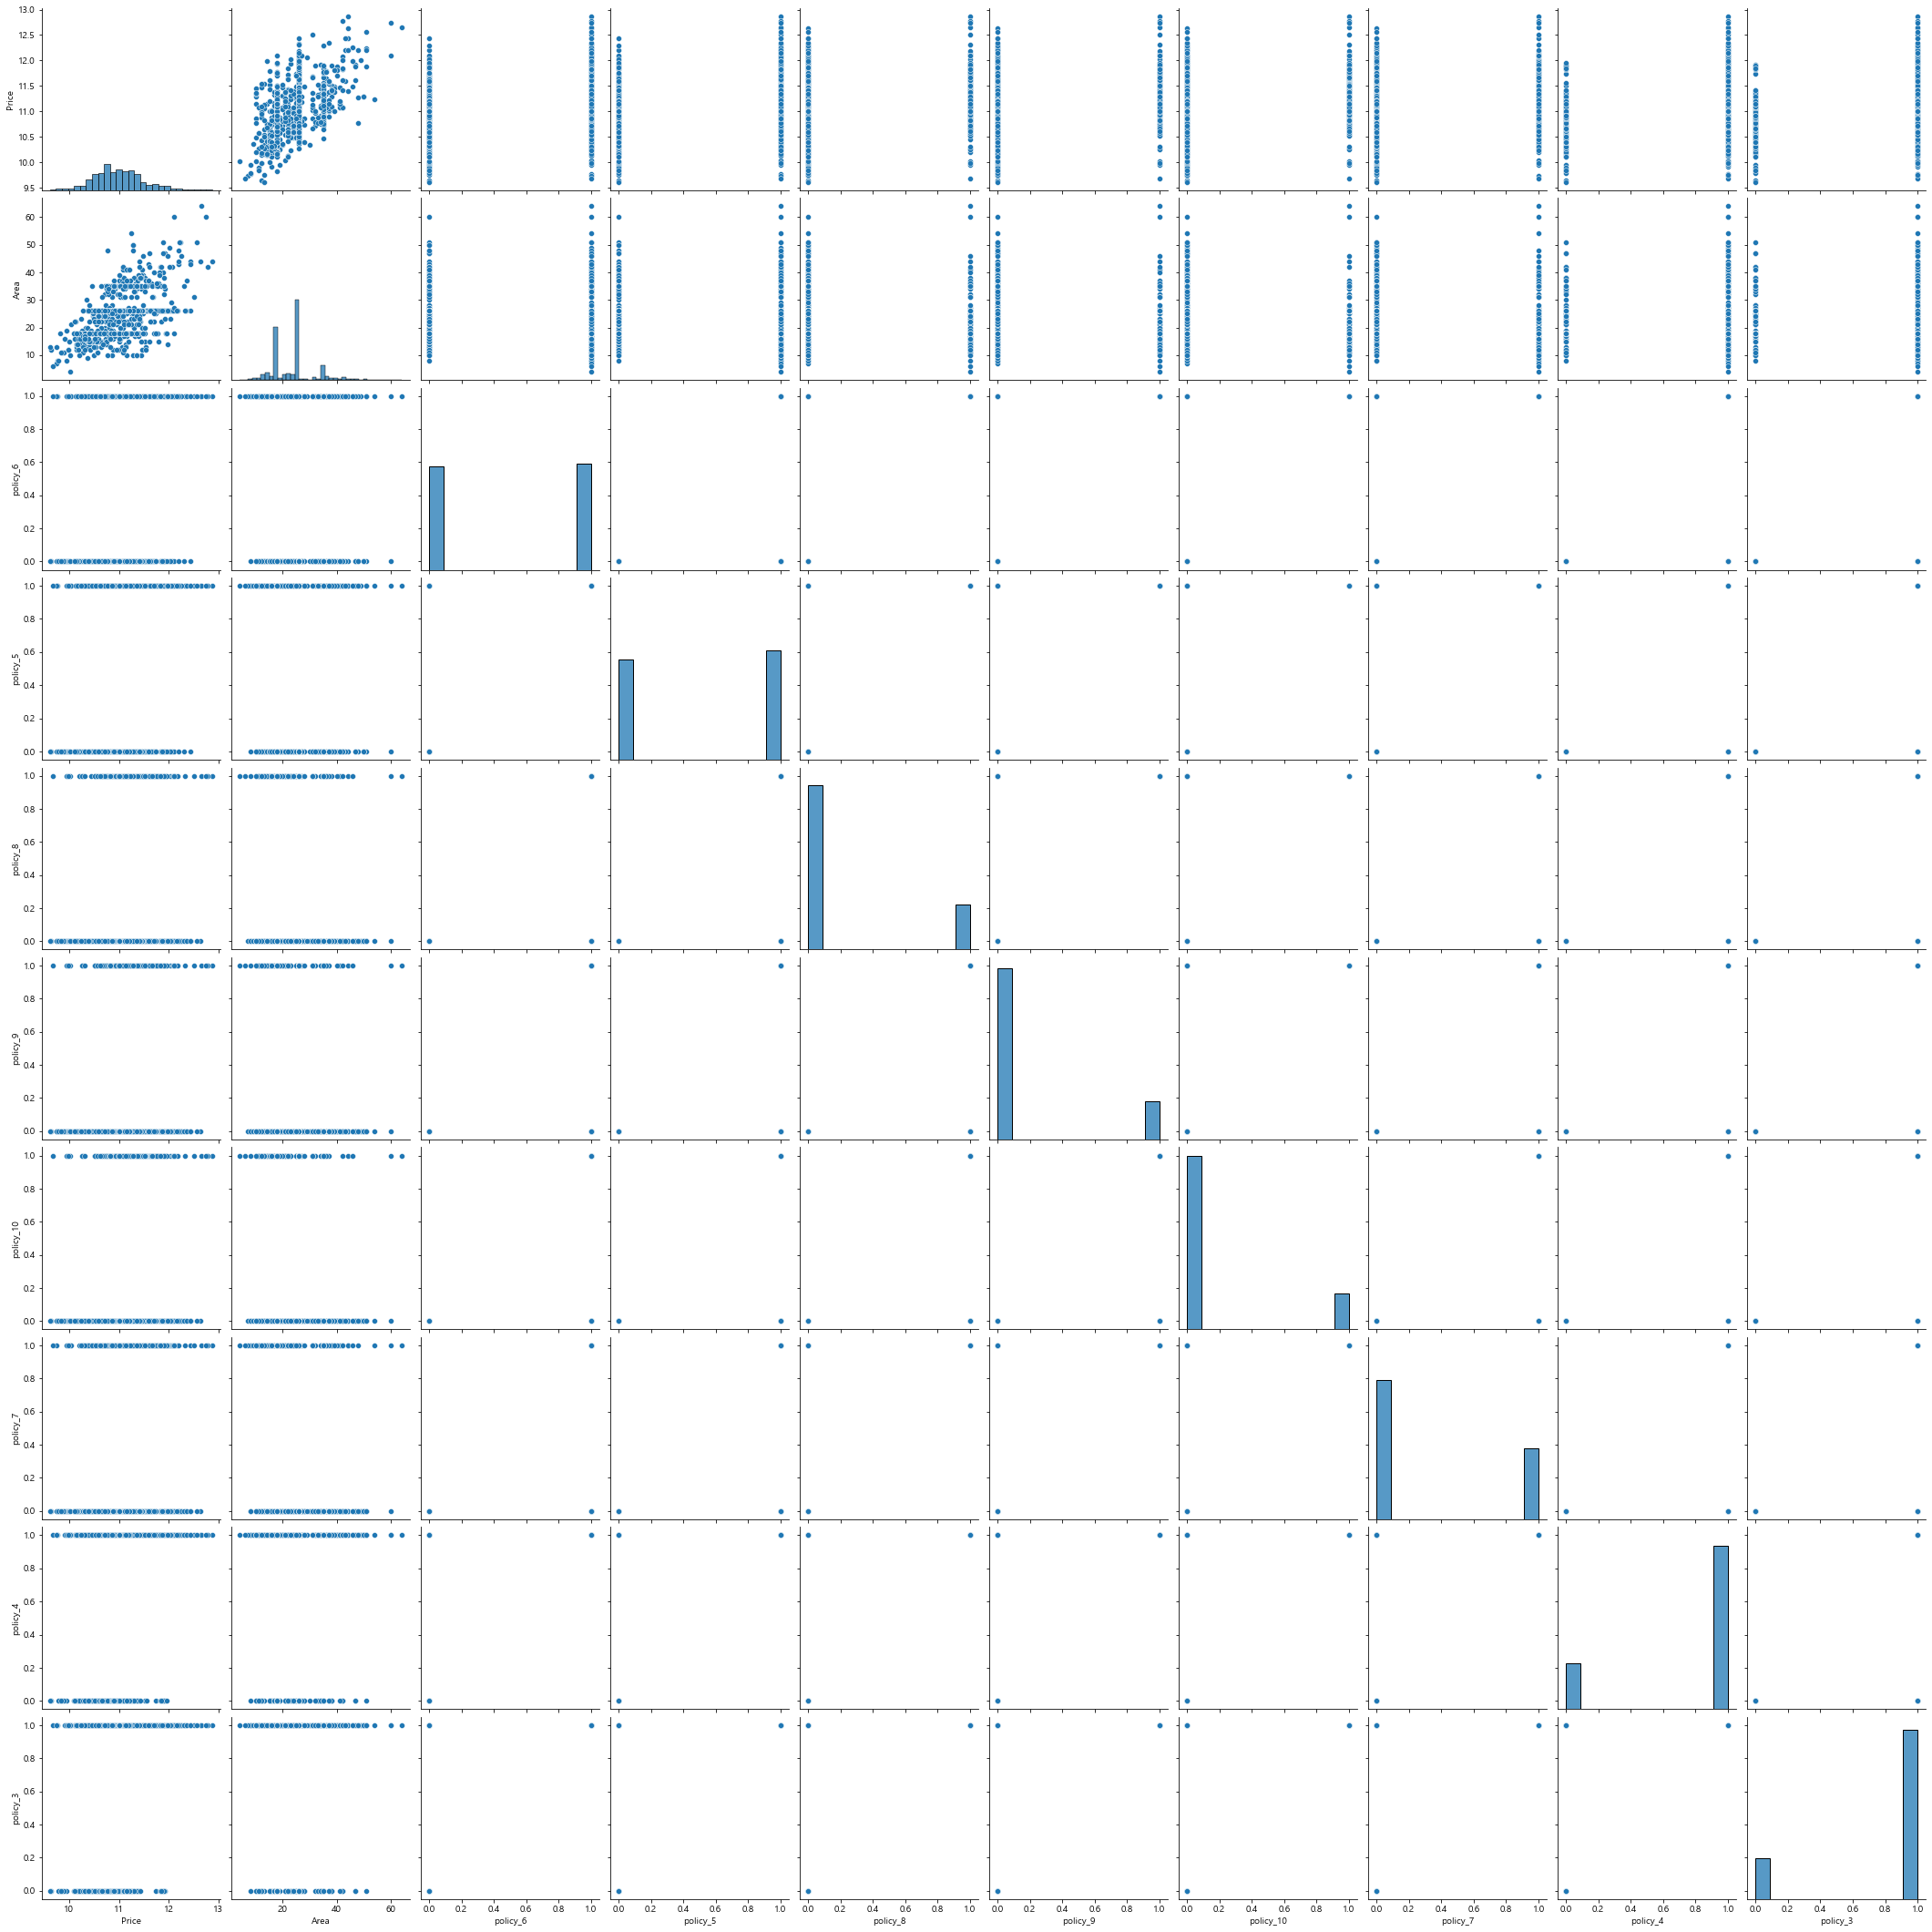

In [20]:
sns.pairplot(train_df[col], height=3)

In [23]:
list(train_df.select_dtypes(include=[object]))

['ComplexName', 'Addr', 'heating', 'contract']

일단 인코딩 안된 상태에서 돌렸기 때문에 아래 항목들 제외함!

In [24]:
train_df.drop(["ComplexName", "Addr", "heating", "contract"], axis=1, inplace=True)

In [25]:
# 정규화 모델 준비
scaler = StandardScaler()

# train 데이터 정규화 시키기
scaler.fit(train_df)

StandardScaler()

In [26]:
# train/test : 기준 동일
X_train = scaler.transform(train_df)
X_train = pd.DataFrame(X_train)

In [31]:
X_test = scaler.transform(test_df)
X_test = pd.DataFrame(X_test)

In [28]:
test_df.drop(["ComplexName", "Addr", "heating", "contract"], axis=1, inplace=True)

In [29]:
test_df.drop("Price", axis=1, inplace=True)

In [32]:
print(X_train.shape)
print(X_test.shape)

(13932, 32)
(5971, 32)


In [32]:
# 참고로 원래의 데이터가 train / test 가 1456개, 1459개로 거의 동일한 크기의 데이터가 주어진 것!!!
print("training shape:{}, test shape:{}".format(X_train.shape,X_test.shape))

training shape:(1000, 31), test shape:(1000, 31)


In [61]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

# Lasso, Ridge, Elastic -> KernelRidge
from sklearn.linear_model import LassoCV,ElasticNetCV,Lasso,ElasticNet
from sklearn.kernel_ridge import KernelRidge

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Stacking
from mlxtend.regressor import StackingRegressor

# 시간
import time

In [34]:
# 원본 데이터 : 560430
# 정답지 맞는지 확인
np.log1p(560430)

13.236461409545289

### KFOLD 사용 준비

In [50]:
X_train = pd.read_csv("X_train.csv",encoding="cp949")
X_train

In [52]:
y_df = pd.read_csv("y_df.csv",encoding="cp949")
y_df

,Price
0,11.002117
1,12.672950
2,11.112463
3,11.123594
4,11.350418
...,...
995,10.757924
996,11.884496
997,10.621352
998,10.714440


In [53]:
kfold_num = 6
kfold = KFold(n_splits=kfold_num, shuffle=True, random_state=0)

In [56]:
# 평가 지표 수정 필요
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_df, cv=kfold, scoring='neg_mean_squared_error'))
    return rmse

## 4.2 일반적인 KR 모델

In [37]:
from sklearn.kernel_ridge import KernelRidge

In [38]:
kr_model = KernelRidge()
score = rmse_cv(kr_model)
print(score.mean())
print(score.std())

11.39082127073003
0.11269342177701115


In [39]:
# KernelRidge -> RandomGridsearch
kr_model = KernelRidge()

t1 = time.time()
kr_model_parameters = {
    "alpha" : [ 0.000001, 0.0001,0.01, 1, 5, 10],
    
    "kernel" : ["linear", "rbf","polynomial"],
    "gamma" : np.logspace(-15, 4, num=4, base =2),
    "degree" : [2,3],
    "coef0" : [0.5, 1.0, 1.5,2]
}
# RGS
n_iter_search = 20
kr_rgs_model = RandomizedSearchCV(
    kr_model, 
    param_distributions=kr_model_parameters,
    n_iter=n_iter_search,
    cv = kfold,
    scoring = "neg_root_mean_squared_error", 
    random_state=1234,
    n_jobs=-1,
    verbose=2
)
kr_rgs_model_result = kr_rgs_model.fit(X_train, y_df)
t2 = time.time()
print("Process Time", str(t2-t1))

Fitting 6 folds for each of 20 candidates, totalling 120 fits
Process Time 10.319427728652954


In [40]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.359156,-0.815455,0.560499,1.180959,-0.473611,-0.201179,-1.707718,-0.199172,-0.120041,-0.607002,...,0.401796,0.476439,0.492175,0.531085,0.955011,0.990050,1.405770,1.899551,2.105892,2.186400
1,-0.160303,-1.172094,0.819510,1.011306,-0.163478,-0.604148,-0.468145,0.301679,-0.218942,0.301430,...,0.401796,0.476439,0.492175,0.531085,0.955011,0.990050,1.405770,1.899551,2.105892,2.186400
2,0.219562,1.146059,0.042478,-0.770058,-0.408777,-0.491949,1.597810,0.468630,-0.392018,0.746740,...,0.401796,0.476439,0.492175,0.531085,-1.047108,-1.010051,-0.711354,-0.526440,-0.474858,-0.457373
3,-0.793411,-0.280497,0.301489,-1.872807,-0.030159,-0.672100,-1.707718,-2.202576,0.399189,-1.595590,...,0.401796,0.476439,0.492175,0.531085,-1.047108,-1.010051,-0.711354,-0.526440,-0.474858,-0.457373
4,-0.793411,-1.350414,0.042478,-1.194192,-0.465546,0.097492,0.358237,1.470332,0.300288,0.657678,...,0.401796,0.476439,0.492175,0.531085,-1.047108,-1.010051,-0.711354,-0.526440,-0.474858,-0.457373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.092940,-0.815455,1.596543,0.502345,2.353532,-0.814324,0.978023,-0.032221,3.687643,3.855003,...,0.401796,0.476439,0.492175,0.531085,0.955011,0.990050,1.405770,-0.526440,-0.474858,-0.457373
996,-1.046654,0.076142,0.042478,1.011306,-0.467867,-0.702125,-0.261550,-0.366122,-0.144766,0.141119,...,0.401796,0.476439,0.492175,0.531085,0.955011,0.990050,1.405770,1.899551,2.105892,2.186400
997,1.612399,0.789420,-0.216533,-0.515578,-0.211162,-0.002065,0.771428,-0.199172,-0.120041,-0.482315,...,0.401796,-2.098906,-2.031798,-1.882938,-1.047108,-1.010051,-0.711354,-0.526440,-0.474858,-0.457373
998,-0.160303,-1.172094,0.690005,0.502345,3.540552,-0.836448,-1.294527,-1.868676,-0.614545,-0.829657,...,0.401796,0.476439,0.492175,0.531085,0.955011,0.990050,1.405770,-0.526440,-0.474858,-0.457373


In [41]:
y_df

0      11.350418
1      11.034906
2      11.686887
3      10.368824
4      10.950824
         ...    
995    10.859018
996    10.308986
997    11.147657
998    10.239996
999     9.975855
Name: Price, Length: 1000, dtype: float64

In [42]:
kr_rgs_model.best_score_

-0.3590012311551636

In [43]:
kr_rgs_model_result.best_params_

{'kernel': 'polynomial',
 'gamma': 3.0517578125e-05,
 'degree': 3,
 'coef0': 1.5,
 'alpha': 0.01}

In [44]:
kr_rgs_model_result.cv_results_['split0_test_score']

array([ -0.39287183,  -1.06113262, -11.29482954, -11.31001749,
       -11.29482954, -11.31001749,  -0.38150155, -11.31001527,
        -0.6044176 , -11.29482954, -11.30814165, -11.30999615,
       -11.30814165,  -0.59345401,  -0.51263044, -11.31001527,
        -0.51838094, -11.30999615,  -0.51263044, -10.92376631])

In [45]:
kr_rgs_model_result.cv_results_['params']

[{'kernel': 'polynomial',
  'gamma': 3.0517578125e-05,
  'degree': 3,
  'coef0': 1.5,
  'alpha': 0.01},
 {'kernel': 'polynomial',
  'gamma': 0.19842513149602486,
  'degree': 3,
  'coef0': 1.5,
  'alpha': 1},
 {'kernel': 'linear',
  'gamma': 0.002460783300575922,
  'degree': 2,
  'coef0': 1.5,
  'alpha': 10},
 {'kernel': 'linear',
  'gamma': 0.19842513149602486,
  'degree': 3,
  'coef0': 1.5,
  'alpha': 1e-06},
 {'kernel': 'linear',
  'gamma': 0.19842513149602486,
  'degree': 3,
  'coef0': 1.5,
  'alpha': 10},
 {'kernel': 'linear',
  'gamma': 16.0,
  'degree': 3,
  'coef0': 1.5,
  'alpha': 1e-06},
 {'kernel': 'polynomial',
  'gamma': 3.0517578125e-05,
  'degree': 3,
  'coef0': 1.5,
  'alpha': 1e-06},
 {'kernel': 'linear',
  'gamma': 3.0517578125e-05,
  'degree': 2,
  'coef0': 2,
  'alpha': 0.0001},
 {'kernel': 'polynomial',
  'gamma': 0.002460783300575922,
  'degree': 2,
  'coef0': 1.0,
  'alpha': 1e-06},
 {'kernel': 'linear',
  'gamma': 0.002460783300575922,
  'degree': 3,
  'coef0': 0

In [46]:
# 모델 실행 결과
model = kr_rgs_model_result
f = model.best_params_ 
best_model_pos = model.cv_results_["params"].index(f) 

best_score_list = []
for i in range(kfold_num):
    k = "split"+str(i) + "_test_score"
    best_score_list.append(model.cv_results_[k][best_model_pos])

best_score_list = np.array(best_score_list)
print(best_score_list)
print("Best Model CV RMSE Mean :",best_score_list.mean())
print("Best Model CV RMSE Std",best_score_list.std())

[-0.39287183 -0.36431844 -0.37061037 -0.34038209 -0.35320879 -0.33261587]
Best Model CV RMSE Mean : -0.3590012311551636
Best Model CV RMSE Std 0.019944401204944708


## 4.3 Lasso 회귀 모델

In [47]:
from sklearn.linear_model import Lasso

In [48]:
lasso_model = Lasso(random_state=1234, normalize=False)
lasso_scores = rmse_cv(lasso_model)
print(lasso_scores.mean())
print(lasso_scores.std())

0.49350784148649113
0.01784592458545018


In [49]:
# Lasso -> RandomGridsearch
lasso_model = Lasso(random_state=1234, normalize=False)

t1 = time.time()
parameters = {
    "alpha" : [ 0.000001, 0.0001,0.01, 1, 5, 10],
    "tol" : [0.000001, 0.00001, 0.001], 
    "max_iter" : [1000, 2000]
}
# RGS
n_iter_search = 20
lasso_rgs_model = RandomizedSearchCV(
    lasso_model, 
    param_distributions=parameters,
    n_iter=n_iter_search,
    cv = kfold,
    scoring = "neg_root_mean_squared_error", 
    random_state=1234,
    n_jobs=-1,
    verbose=2
)

lasso_rgs_model.fit(X_train, y_df)
t2 = time.time()
print("Process Time", str(t2-t1))

Fitting 6 folds for each of 20 candidates, totalling 120 fits
Process Time 0.4956488609313965


In [50]:
lasso_rgs_model.best_score_

-0.3600322296570684

In [51]:
lasso_rgs_model.best_params_

{'tol': 0.001, 'max_iter': 1000, 'alpha': 0.0001}

In [52]:
def cvmodel_results(m):
    model = m
    f = model.best_params_ 
    best_model_pos = model.cv_results_["params"].index(f)
    best_score_list = []
    for i in range(kfold_num):
        k = "split"+str(i) + "_test_score"
        best_score_list.append(model.cv_results_[k][best_model_pos])
    best_score_list = np.array(best_score_list)
    print("Best Model CV Parameter:", f)
    print("Best Model CV Results :",best_score_list)
    print("Best Model CV RMSE Mean :",best_score_list.mean())
    print("Best Model CV RMSE Std",best_score_list.std())

In [53]:
cvmodel_results(lasso_rgs_model)

Best Model CV Parameter: {'tol': 0.001, 'max_iter': 1000, 'alpha': 0.0001}
Best Model CV Results : [-0.39435327 -0.36399845 -0.37323814 -0.34139508 -0.35332199 -0.33388643]
Best Model CV RMSE Mean : -0.3600322296570684
Best Model CV RMSE Std 0.02018264169965942


## 4.4 Elastic Net 회귀 모델
- 오류나는듯? 
- 하이퍼 파라미터 변경 필요해보임

In [54]:
from sklearn.linear_model import ElasticNet

In [55]:
elnet_model = ElasticNet(random_state=1234, normalize=False)
scores = rmse_cv(elnet_model)
print(scores.mean())
print(scores.std())

0.49350784148649113
0.01784592458545018


In [56]:
# elastic -> RandomGridsearch
elnet_model = ElasticNet(random_state=1234, normalize=False)

t1 = time.time()
parameters = {
    "alpha" : [ 0.000001, 0.0001,0.01, 1, 5, 10],
    "l1_ratio" : [ 0.000001, 0.0001,0.01, 1, 5, 10], 
    "tol" : [0.000001, 0.00001, 0.001], 
    "max_iter" : [1000, 2000]
}

# RGS
n_iter_search = 20
elnet_rgs_model = RandomizedSearchCV(
    elnet_model, 
    param_distributions=parameters,
    n_iter=n_iter_search,
    cv = kfold,
    scoring = "neg_root_mean_squared_error", 
    random_state=1234,
    n_jobs=-1,
    verbose=2
)
elnet_rgs_model.fit(X_train, y_df)
t2 = time.time()
print("Process Time", str(t2-t1))


Fitting 6 folds for each of 20 candidates, totalling 120 fits
Process Time 0.5211851596832275


C:\Users\CPBUserN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.36009606 -0.36009099 -0.36009606 -0.35970069 -0.38977407 -0.36009054
 -0.43622797 -0.35970101 -0.36278965 -0.36009606 -0.36009054         nan
 -0.36009606 -0.43608034         nan         nan         nan -0.47797698
         nan -0.47797698]
  warnings.warn(


In [57]:
elnet_rgs_model.best_score_

-0.35970068626673374

In [58]:
elnet_rgs_model.best_params_

{'tol': 0.001, 'max_iter': 2000, 'l1_ratio': 0.0001, 'alpha': 0.01}

In [59]:
cvmodel_results(elnet_rgs_model)

Best Model CV Parameter: {'tol': 0.001, 'max_iter': 2000, 'l1_ratio': 0.0001, 'alpha': 0.01}
Best Model CV Results : [-0.39389345 -0.36393336 -0.37258685 -0.34119408 -0.35311273 -0.33348366]
Best Model CV RMSE Mean : -0.35970068626673374
Best Model CV RMSE Std 0.02010945884951458


In [75]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

## 4.5 XGBOOST 모델

In [68]:
from xgboost import XGBRegressor

In [61]:
xgb_model = XGBRegressor(n_jobs=-1,random_state=1234,objective ="reg:squarederror")

scores = rmse_cv(xgb_model)
print(scores.mean())
print(scores.std())

0.3377833665431444
0.021963218988176207


In [62]:
# XGB -> RandomGridsearch
xgb_model = XGBRegressor(n_jobs=-1,random_state=1234,objective ="reg:squarederror")

t1 = time.time()
parameters = {
    # 여러 모델들을 통해 에러 최소화
    "n_estimators" : [50, 100,300,1000,2000],
    "learning_rate" : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    
    # 하이퍼 파라미터
    "max_depth":[2,3,4,5,6,7,8],
    "colsample_bytree": [0.3, 0.6, 0.9],
    "reg_alpha" : [0, 0.1, 0.01, 0.5],
    "reg_lambda" : [0, 0.1, 0.01,0.5]
}

# RGS
n_iter_search = 20
xgb_rgs_model = RandomizedSearchCV(
    xgb_model, 
    param_distributions=parameters,
    n_iter=n_iter_search,
    cv = kfold,
    scoring = "neg_root_mean_squared_error", 
    random_state=1234,
    n_jobs=-1,
    verbose=2
)
xgb_rgs_model.fit(X_train, y_df)
t2 = time.time()
print("Process Time", str(t2-t1))

Fitting 6 folds for each of 20 candidates, totalling 120 fits
Process Time 54.22322177886963


In [63]:
xgb_rgs_model.best_score_

-0.32055854435772585

In [ ]:
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

In [232]:
xgb_rgs_model.best_score_

-0.32055854435772585

## 4.6 Light GBM모델

In [57]:
lgbm_model = LGBMRegressor(n_jobs =-1, random_state = 1234 )
scores = rmse_cv(lgbm_model)
print(scores.mean())
print(scores.std())

0.301837324426164
0.02463082149297293


In [58]:
# lightgbm -> RandomGrid Search
lgbm_model = LGBMRegressor(n_jobs =-1, random_state = 1234 )

t1 = time.time()
parameters = {
    # 이어 달리기를 할 친구 스타일!!! -> tree -> overfit!!!!!
    "boosting_type":[ "gbdt", "goss","dart", "rf"],

    
    # 몇 명을 뽑아서 이어달리기를 할지,
    # 이어달리기를 하는 과정을 얼마나 디테일하게 할지...
    "n_estimators" : [50,150,100,300,200],
     "min_child_weight":[0.5, 1, 5,10,3],
    
    # 규약
    "reg_alpha" : [0, 0.1, 0.01, 0.05],
    "reg_lambda" :  [0, 0.1, 0.01, 0.05,0.005]
    
}


# RGS
n_iter_search = 10
lgbm_rgs_model = RandomizedSearchCV(
    lgbm_model, 
    param_distributions=parameters,
    n_iter=n_iter_search,
    cv = kfold,
    scoring = "neg_root_mean_squared_error", 
    random_state=1234,
    n_jobs=-1,
    verbose=2
)
lgbm_rgs_model.fit(X_train, y_df)
t2 = time.time()
print("Process Time", str(t2-t1))



Fitting 6 folds for each of 10 candidates, totalling 60 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.3174523  -0.30970305 -1.28892713 -0.51634795 -5.91769333 -7.099052
 -0.3120326          nan -0.30895419 -0.30863124]
  warnings.warn(


Process Time 4.416646242141724


In [59]:
lgbm_rgs_model.best_score_

-0.30863123724744074

In [60]:
lgbm_rgs_model.best_params_

{'reg_lambda': 0.005,
 'reg_alpha': 0.05,
 'n_estimators': 300,
 'min_child_weight': 5,
 'boosting_type': 'gbdt'}

In [74]:
kr_best_model = kr_rgs_model_result.best_estimator_
y_pred = kr_best_model.predict(X_test) # 가격의 범위는 log를 취한 범위!!!!
y_summision_1 = np.expm1(y_pred)
y_summision_1

array([ 58978.88355905,  74161.43757287,  42456.14354838,  57513.3504253 ,
        41566.41659531,  81558.62890308,  39926.89657661,  48026.3420928 ,
        35754.7646941 ,  68537.91701969,  33662.67288109,  59019.51945061,
        63760.61918306,  99638.03594007,  67101.14763467,  35963.96043008,
        42602.35490275,  64119.24543633,  34382.95738685,  86105.60715428,
        56559.03025956,  49935.22975867, 143747.41562872,  69815.31992862,
        61836.49270309,  49868.24505868,  87156.17164843,  91521.95768823,
        45040.92488382,  71524.70855388,  66626.53244877,  67981.57215227,
        53583.67563809,  35565.72198919, 109483.13720333,  55109.40942039,
        49695.53846017,  60555.79157648,  75649.88626162, 118888.27358494,
        91697.97821061,  61718.13356237,  54333.40058538,  49683.31035667,
        45376.91179024,  50145.90081423,  39890.63665057,  56630.30867952,
        46355.29590576,  70653.11671665,  25646.02713779,  48216.04117918,
        64837.83655747,  

In [78]:
lasso_best_model = lasso_rgs_model.best_estimator_
y_pred = lasso_best_model.predict(X_test) # 가격의 범위는 log를 취한 범위!!!!
y_summision_2 = np.expm1(y_pred)
y_summision_2

array([ 59142.59207955,  75631.88409514,  41683.82629167,  57389.4110756 ,
        41023.91177078,  83369.00241447,  39674.57425005,  47415.48521206,
        35140.87408666,  68459.69965209,  33031.2257801 ,  57863.80680828,
        64065.77419876, 100744.72764571,  68612.72931243,  35723.97523552,
        42083.03819784,  64440.69667076,  33279.62534797,  87778.66565819,
        56226.33709977,  50183.90380236, 145835.86902967,  70618.44568508,
        62086.82592293,  49610.32857385,  89809.378701  ,  93323.04831489,
        44730.88695758,  72563.4871654 ,  66857.7224298 ,  68249.65808997,
        53471.92182993,  34515.95103224, 112703.76820797,  55205.21064798,
        51370.41275226,  60190.58388255,  76536.51825165, 122517.8181074 ,
        92762.66715788,  61102.88088288,  53997.62266705,  49518.69870877,
        44934.64252219,  49674.70709535,  39388.53615619,  57631.87578898,
        45680.77032815,  71252.89164173,  24520.19599532,  47184.00573549,
        65175.41669028,  

In [79]:
elnet_best_model = elnet_rgs_model.best_estimator_
y_pred = elnet_best_model.predict(X_test) # 가격의 범위는 log를 취한 범위!!!!
y_summision_3 = np.expm1(y_pred)
y_summision_3

array([ 59135.61098064,  74985.92203128,  41867.18461479,  57440.005869  ,
        41154.38539517,  83099.00102202,  39746.35801237,  47568.45171446,
        35263.48146778,  68454.05745525,  33167.54850423,  58172.78804406,
        64033.42220509, 100564.05888482,  68393.86578832,  35789.10390695,
        42200.93674735,  64359.14163053,  33520.09210843,  87455.77594247,
        56265.32254703,  50135.07530085, 145546.94709317,  70475.31127951,
        62038.06315879,  49647.13160821,  89350.49251181,  92983.69633455,
        44793.87536373,  72322.31265724,  66805.19566748,  68214.05954947,
        53528.06548034,  34752.85916217, 112314.98009716,  55138.0396931 ,
        50759.0359841 ,  60341.7624351 ,  76353.99601966, 121715.77562358,
        92514.2569795 ,  61256.24129874,  54052.78307583,  49524.11598134,
        45024.66900693,  49770.64901171,  39499.66306924,  57448.50436378,
        45838.11473354,  71105.55573927,  24763.34148896,  47442.69827008,
        65227.49037751,  

In [89]:
# 아까 분명 됐는데 오류남;;; (NameError: name 'xgb_rgs_model_result' is not defined)

xgb_best_model = xgb_rgs_modelt.best_estimator_
y_pred = xgb_best_model.predict(X_test) 
y_summision_4 = np.expm1(y_pred)
y_summision_4

NameError: name 'xgb_rgs_model_result' is not defined

In [76]:
# 4개의 모델 평균
y_tot_avg =  (y_summision_1 + y_summision_2 + y_summision_3 + y_summision_4 + y_summision_5 + y_summision_6)/6

NameError: name 'y_summision_2' is not defined

In [80]:
# TOP 3
y_tot_top3 = (y_summision_1 + y_summision_3 + y_summision_6) / 3

In [81]:
# 가중치 조절
y_tot_w_top3_ = (2*y_summision_1 + 1*y_summision_3 + 2* y_summision_6) / 5

In [82]:
test_temp = pd.read_csv("data/test.csv", encoding='cp949')
test_id = test_temp
test_id

,ComplexName,Area,Price,Floor,Construct,Addr,gu,apt,household,floor_low,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,벽산라이브파크,18.0,38000,13,2004,서울특별시 강북구 미아동1354,1130500000,3099,1585,5,...,1,1,1,1,1,1,0,0,0,0
1,동원베네스트,26.0,100000,4,2008,서울특별시 동작구 상도동528,1135000000,11681,205,8,...,1,1,1,1,1,1,1,1,1,0
2,경남,15.0,31400,15,1989,서울특별시 노원구 중계동505,1168000000,3048,348,20,...,1,1,1,1,0,0,0,0,0,0
3,성원,18.0,37900,16,1998,서울특별시 광진구 중곡동681,1174000000,3067,74,16,...,1,1,1,1,1,1,0,0,0,0
4,한신,13.0,30800,10,1987,서울특별시 중랑구 면목동193-1,1135000000,263,1200,15,...,1,1,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,현대,23.0,51300,15,1994,서울특별시 중랑구 면목동1502,1168000000,973,120,15,...,1,1,1,1,1,1,1,0,0,0
996,두산,26.0,56000,11,1998,서울특별시 성북구 석관동10,1120000000,8854,251,10,...,1,1,1,1,0,0,0,0,0,0
997,현대,25.0,80000,7,1994,서울특별시 영등포구 당산동2가164,1130500000,1339,90,16,...,1,1,1,1,1,1,0,0,0,0
998,건영,14.0,31300,6,1988,서울특별시 노원구 하계동271-3,1135000000,1085,90,13,...,1,1,1,1,1,1,1,0,0,0


In [256]:
my_submission = pd.DataFrame()
my_submission['Price'] = y_tot_avg 
my_submission.to_csv('submission_trail_ver_0-1.csv',index=False)

In [86]:
kr_best_model = kr_rgs_model_result.best_estimator_
y_pred = kr_best_model.predict(X_test)
y_summision_1 = np.expm1(y_pred)
y_summision_1

array([ 58978.88355905,  74161.43757287,  42456.14354838,  57513.3504253 ,
        41566.41659531,  81558.62890308,  39926.89657661,  48026.3420928 ,
        35754.7646941 ,  68537.91701969,  33662.67288109,  59019.51945061,
        63760.61918306,  99638.03594007,  67101.14763467,  35963.96043008,
        42602.35490275,  64119.24543633,  34382.95738685,  86105.60715428,
        56559.03025956,  49935.22975867, 143747.41562872,  69815.31992862,
        61836.49270309,  49868.24505868,  87156.17164843,  91521.95768823,
        45040.92488382,  71524.70855388,  66626.53244877,  67981.57215227,
        53583.67563809,  35565.72198919, 109483.13720333,  55109.40942039,
        49695.53846017,  60555.79157648,  75649.88626162, 118888.27358494,
        91697.97821061,  61718.13356237,  54333.40058538,  49683.31035667,
        45376.91179024,  50145.90081423,  39890.63665057,  56630.30867952,
        46355.29590576,  70653.11671665,  25646.02713779,  48216.04117918,
        64837.83655747,  

In [87]:
lasso_best_model = lasso_rgs_model.best_estimator_
y_pred = lasso_best_model.predict(X_test) 
y_summision_2 = np.expm1(y_pred)
y_summision_2

array([ 59142.59207955,  75631.88409514,  41683.82629167,  57389.4110756 ,
        41023.91177078,  83369.00241447,  39674.57425005,  47415.48521206,
        35140.87408666,  68459.69965209,  33031.2257801 ,  57863.80680828,
        64065.77419876, 100744.72764571,  68612.72931243,  35723.97523552,
        42083.03819784,  64440.69667076,  33279.62534797,  87778.66565819,
        56226.33709977,  50183.90380236, 145835.86902967,  70618.44568508,
        62086.82592293,  49610.32857385,  89809.378701  ,  93323.04831489,
        44730.88695758,  72563.4871654 ,  66857.7224298 ,  68249.65808997,
        53471.92182993,  34515.95103224, 112703.76820797,  55205.21064798,
        51370.41275226,  60190.58388255,  76536.51825165, 122517.8181074 ,
        92762.66715788,  61102.88088288,  53997.62266705,  49518.69870877,
        44934.64252219,  49674.70709535,  39388.53615619,  57631.87578898,
        45680.77032815,  71252.89164173,  24520.19599532,  47184.00573549,
        65175.41669028,  

In [88]:
elnet_best_model = elnet_rgs_model.best_estimator_
y_pred = elnet_best_model.predict(X_test) 
y_summision_3 = np.expm1(y_pred)
y_summision_3

array([ 59135.61098064,  74985.92203128,  41867.18461479,  57440.005869  ,
        41154.38539517,  83099.00102202,  39746.35801237,  47568.45171446,
        35263.48146778,  68454.05745525,  33167.54850423,  58172.78804406,
        64033.42220509, 100564.05888482,  68393.86578832,  35789.10390695,
        42200.93674735,  64359.14163053,  33520.09210843,  87455.77594247,
        56265.32254703,  50135.07530085, 145546.94709317,  70475.31127951,
        62038.06315879,  49647.13160821,  89350.49251181,  92983.69633455,
        44793.87536373,  72322.31265724,  66805.19566748,  68214.05954947,
        53528.06548034,  34752.85916217, 112314.98009716,  55138.0396931 ,
        50759.0359841 ,  60341.7624351 ,  76353.99601966, 121715.77562358,
        92514.2569795 ,  61256.24129874,  54052.78307583,  49524.11598134,
        45024.66900693,  49770.64901171,  39499.66306924,  57448.50436378,
        45838.11473354,  71105.55573927,  24763.34148896,  47442.69827008,
        65227.49037751,  

In [258]:
# meta model을 준비함...
XGB = XGBRegressor()

# train에 대해서 직접 결과값을 내서, 그 결과 값을 다시 특징으로 사용하기 위한 모델..
ELNET = ElasticNet(random_state = 1)
LCV=Lasso(random_state = 1)
KR = KernelRidge() 
XG = XGBRegressor()

# Stacking을 할 모델에 대한 세팅!!!!!!
stack = StackingRegressor(regressors = [ELNET,LCV,XG,SV,KR], meta_regressor = XGB)

params = {       
        # mlxtend : 0.17 이하 버전기준..   
#               'meta-xgbregressor__n_estimators' : [740*2],#740
#               'meta-xgbregressor__learning_rate': [0.01/2], #0.01
#                'meta-xgbregressor__min_child_weight':[0],
#               'meta-xgbregressor__gamma':[0.1],
#               'meta-xgbregressor__max_depth': [2],
#               'meta-xgbregressor__subsample':[0.65],
#               'meta-xgbregressor__colsample_bytree':[0.4],
#               'meta-xgbregressor__reg_alpha':[0],
#               'meta-xgbregressor__reg_lambda':[1],
    
        # mlxtend : 0.17 버전 기준 : http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
            'meta_regressor__n_estimators' : [740*2],#740
            'meta_regressor__learning_rate': [0.01/2], #0.01
            'meta_regressor__min_child_weight':[0],
            'meta_regressor__gamma':[0.1],
            'meta_regressor__max_depth': [2],
            'meta_regressor__subsample':[0.65],
            'meta_regressor__colsample_bytree':[0.4],
            'meta_regressor__reg_alpha':[0],
            'meta_regressor__reg_lambda':[1],
            
    # 개별 모델에 대해서 할 때..
              'lasso__alpha':[0.00244736842105],
              'elasticnet__alpha':[0.0276315789474],
              'elasticnet__l1_ratio':[0.09],
              'xgbregressor__min_child_weight':[0.2],
              'xgbregressor__n_estimators' : [870],
              'xgbregressor__learning_rate': [0.04],
              'xgbregressor__gamma':[0],
              'xgbregressor__max_depth': [3],
              'xgbregressor__subsample':[0.8],
              'xgbregressor__colsample_bytree':[0.7],
    
              'kernelridge__alpha':[0.93],
              'kernelridge__coef0':[1.5],
              'kernelridge__degree':[3],
              'kernelridge__gamma':[0.001],
              'kernelridge__kernel':['polynomial'],
              'kernelridge__kernel_params':[None],
              
              'svr__coef0':[1.6],
              'svr__kernel':['poly'],
              'svr__epsilon':[0.03],
              'svr__gamma': ['auto'],
              'svr__degree': [2],
              'svr__C':[0.1]
}

grid = GridSearchCV(estimator = stack,
                    param_grid=params,
                    cv=kfold,
                    refit=True, verbose=1,n_jobs=-1,
                    scoring="neg_root_mean_squared_error")
grid.fit(X_train, y_df)
grid_best = grid.best_estimator_
print(grid_best)


Fitting 6 folds for each of 1 candidates, totalling 6 fits
StackingRegressor(meta_regressor=XGBRegressor(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.4, gamma=0.1,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.005,
                                              max_delta_step=None, max_depth=2,
                                              min_child_weight=0, missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=1480, n_jobs=N...
                                           monotone_constraints=N

In [259]:
cvmodel_results(grid)

Best Model CV Parameter: {'elasticnet__alpha': 0.0276315789474, 'elasticnet__l1_ratio': 0.09, 'kernelridge__alpha': 0.93, 'kernelridge__coef0': 1.5, 'kernelridge__degree': 3, 'kernelridge__gamma': 0.001, 'kernelridge__kernel': 'polynomial', 'kernelridge__kernel_params': None, 'lasso__alpha': 0.00244736842105, 'meta_regressor__colsample_bytree': 0.4, 'meta_regressor__gamma': 0.1, 'meta_regressor__learning_rate': 0.005, 'meta_regressor__max_depth': 2, 'meta_regressor__min_child_weight': 0, 'meta_regressor__n_estimators': 1480, 'meta_regressor__reg_alpha': 0, 'meta_regressor__reg_lambda': 1, 'meta_regressor__subsample': 0.65, 'svr__C': 0.1, 'svr__coef0': 1.6, 'svr__degree': 2, 'svr__epsilon': 0.03, 'svr__gamma': 'auto', 'svr__kernel': 'poly', 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__gamma': 0, 'xgbregressor__learning_rate': 0.04, 'xgbregressor__max_depth': 3, 'xgbregressor__min_child_weight': 0.2, 'xgbregressor__n_estimators': 870, 'xgbregressor__subsample': 0.8}
Best Model C

In [270]:
y_summision_st = np.expm1(grid.predict(X_test))

#### Ensemble - Averaging

In [271]:
y_final = (y_summision_3 + y_summision_st)/2
y_final = (1*y_summision_3 + 2*y_summision_st)/3

In [273]:
y_submission_avg

NameError: name 'y_submission_avg' is not defined

* 제출 준비

In [274]:
my_submission = pd.DataFrame()
my_submission['SalePrice'] = y_submission_avg


NameError: name 'y_submission_avg' is not defined

In [ ]:
cvmodel_results(grid)

y_submission_st = np.expm1(grid.predict(X_test))

#### Ensemble - Averaging

y_final = (y_summision_3 + y_summision_st)/2
y_final = (1*y_summision_3 + 2*y_summision_st)/3

y_submission_avg

* 제출 준비

my_submission = pd.DataFrame()
my_submission['Id'] = test_id
my_submission['SalePrice'] = y_submission_avg
my_submission.to_csv('submission_trail_ver_0-1.csv',index=False)
